# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [4]:
df = pd.read_csv('./data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [17]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [6]:
# Make a copy of our data
train_df = df.copy()

In [7]:
train_df.dtypes

,0
id,object
cons_12m,float64
cons_gas_12m,float64
cons_last_month,float64
forecast_cons_12m,float64
...,...
channel_lmkebamcaaclubfxadlmueccxoimlema,int64
channel_usilxuppasemubllopkaafesmlibmsdf,int64
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,int64
origin_up_ldkssxwpmemidmecebumciepifcamkci,int64


In [8]:
# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm.

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging.

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [11]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 300, 1000],   # number of trees
    'max_depth': [None, 5, 10],        # maximum depth of trees
    'min_samples_split': [2, 5, 10]    # minimum samples to split a node
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)


Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}
Best cross-validated score: 0.9083441392662802


### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

In [20]:
# Generate predictions here!
y_pred = best_model.predict(X_test)
y_test.value_counts()

,count
churn,
0,3286
1,366


In [18]:
# Calculate performance metrics here!
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.9044359255202629

Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3286
           1       0.87      0.05      0.10       366

    accuracy                           0.90      3652
   macro avg       0.89      0.53      0.53      3652
weighted avg       0.90      0.90      0.86      3652


Confusion Matrix:

[[3283    3]
 [ 346   20]]


## Model Understanding

In [21]:
importances = best_model.feature_importances_
features = X_train.columns

feat_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance.head(10))

                    Feature  Importance
12       margin_net_pow_ele    0.053211
11     margin_gross_pow_ele    0.053142
0                  cons_12m    0.051213
5   forecast_meter_rent_12m    0.047466
14               net_margin    0.044121
3         forecast_cons_12m    0.041819
2           cons_last_month    0.037285
49             months_activ    0.035215
15                  pow_max    0.033236
51        months_modif_prod    0.031622


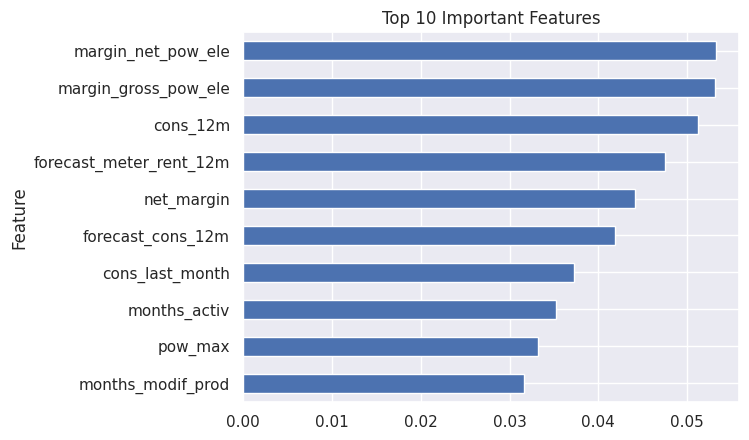

In [22]:
feat_importance.head(10).plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False
)
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features")
plt.show()

Although the Random Forest model achieved a high overall accuracy of 90.4%, it performs poorly in detecting churn customers. The recall for churn is only 5%, meaning the model fails to identify most customers who actually churn.

This occurs due to class imbalance, where non-churn customers dominate the dataset.

Therefore, accuracy alone is not a reliable metric. Recall and F1-score for the churn class are more meaningful.
